In [32]:
import cv2
from doclayout_yolo import YOLOv10

# Load the pre-trained model
model = YOLOv10("/Users/basaravia/Documents/02_Proyectos_IA/genai/local_ocr_dl/models/doclayout_yolo_docstructbench_imgsz1024.pt")
# filepath = hf_hub_download(repo_id="juliozhao/DocLayout-YOLO-DocStructBench", filename="doclayout_yolo_docstructbench_imgsz1024.pt")
# model = YOLOv10(filepath)
#model = YOLOv10.from_pretrained("juliozhao/DocLayout-YOLO-DocStructBench")

# Perform prediction
det_res = model.predict(
    "/Users/basaravia/Documents/02_Proyectos_IA/genai/local_ocr_dl/DocLayout-YOLO/assets/example/academic.jpg",   # Image to predict
    imgsz=1024,        # Prediction image size
    conf=0.2,          # Confidence threshold
    device="mps:0"    # Device to use (e.g., 'cuda:0', 'mps:0' or 'cpu')
)

# Annotate and save the result
annotated_frame = det_res[0].plot(pil=True, line_width=5, font_size=20)
cv2.imwrite("result.jpg", annotated_frame)


image 1/1 /Users/basaravia/Documents/02_Proyectos_IA/genai/local_ocr_dl/DocLayout-YOLO/assets/example/academic.jpg: 1024x736 1 title, 4 plain texts, 4 abandons, 2 figures, 3 figure_captions, 2 tables, 251.9ms
Speed: 16.9ms preprocess, 251.9ms inference, 4.3ms postprocess per image at shape (1, 3, 1024, 736)


True

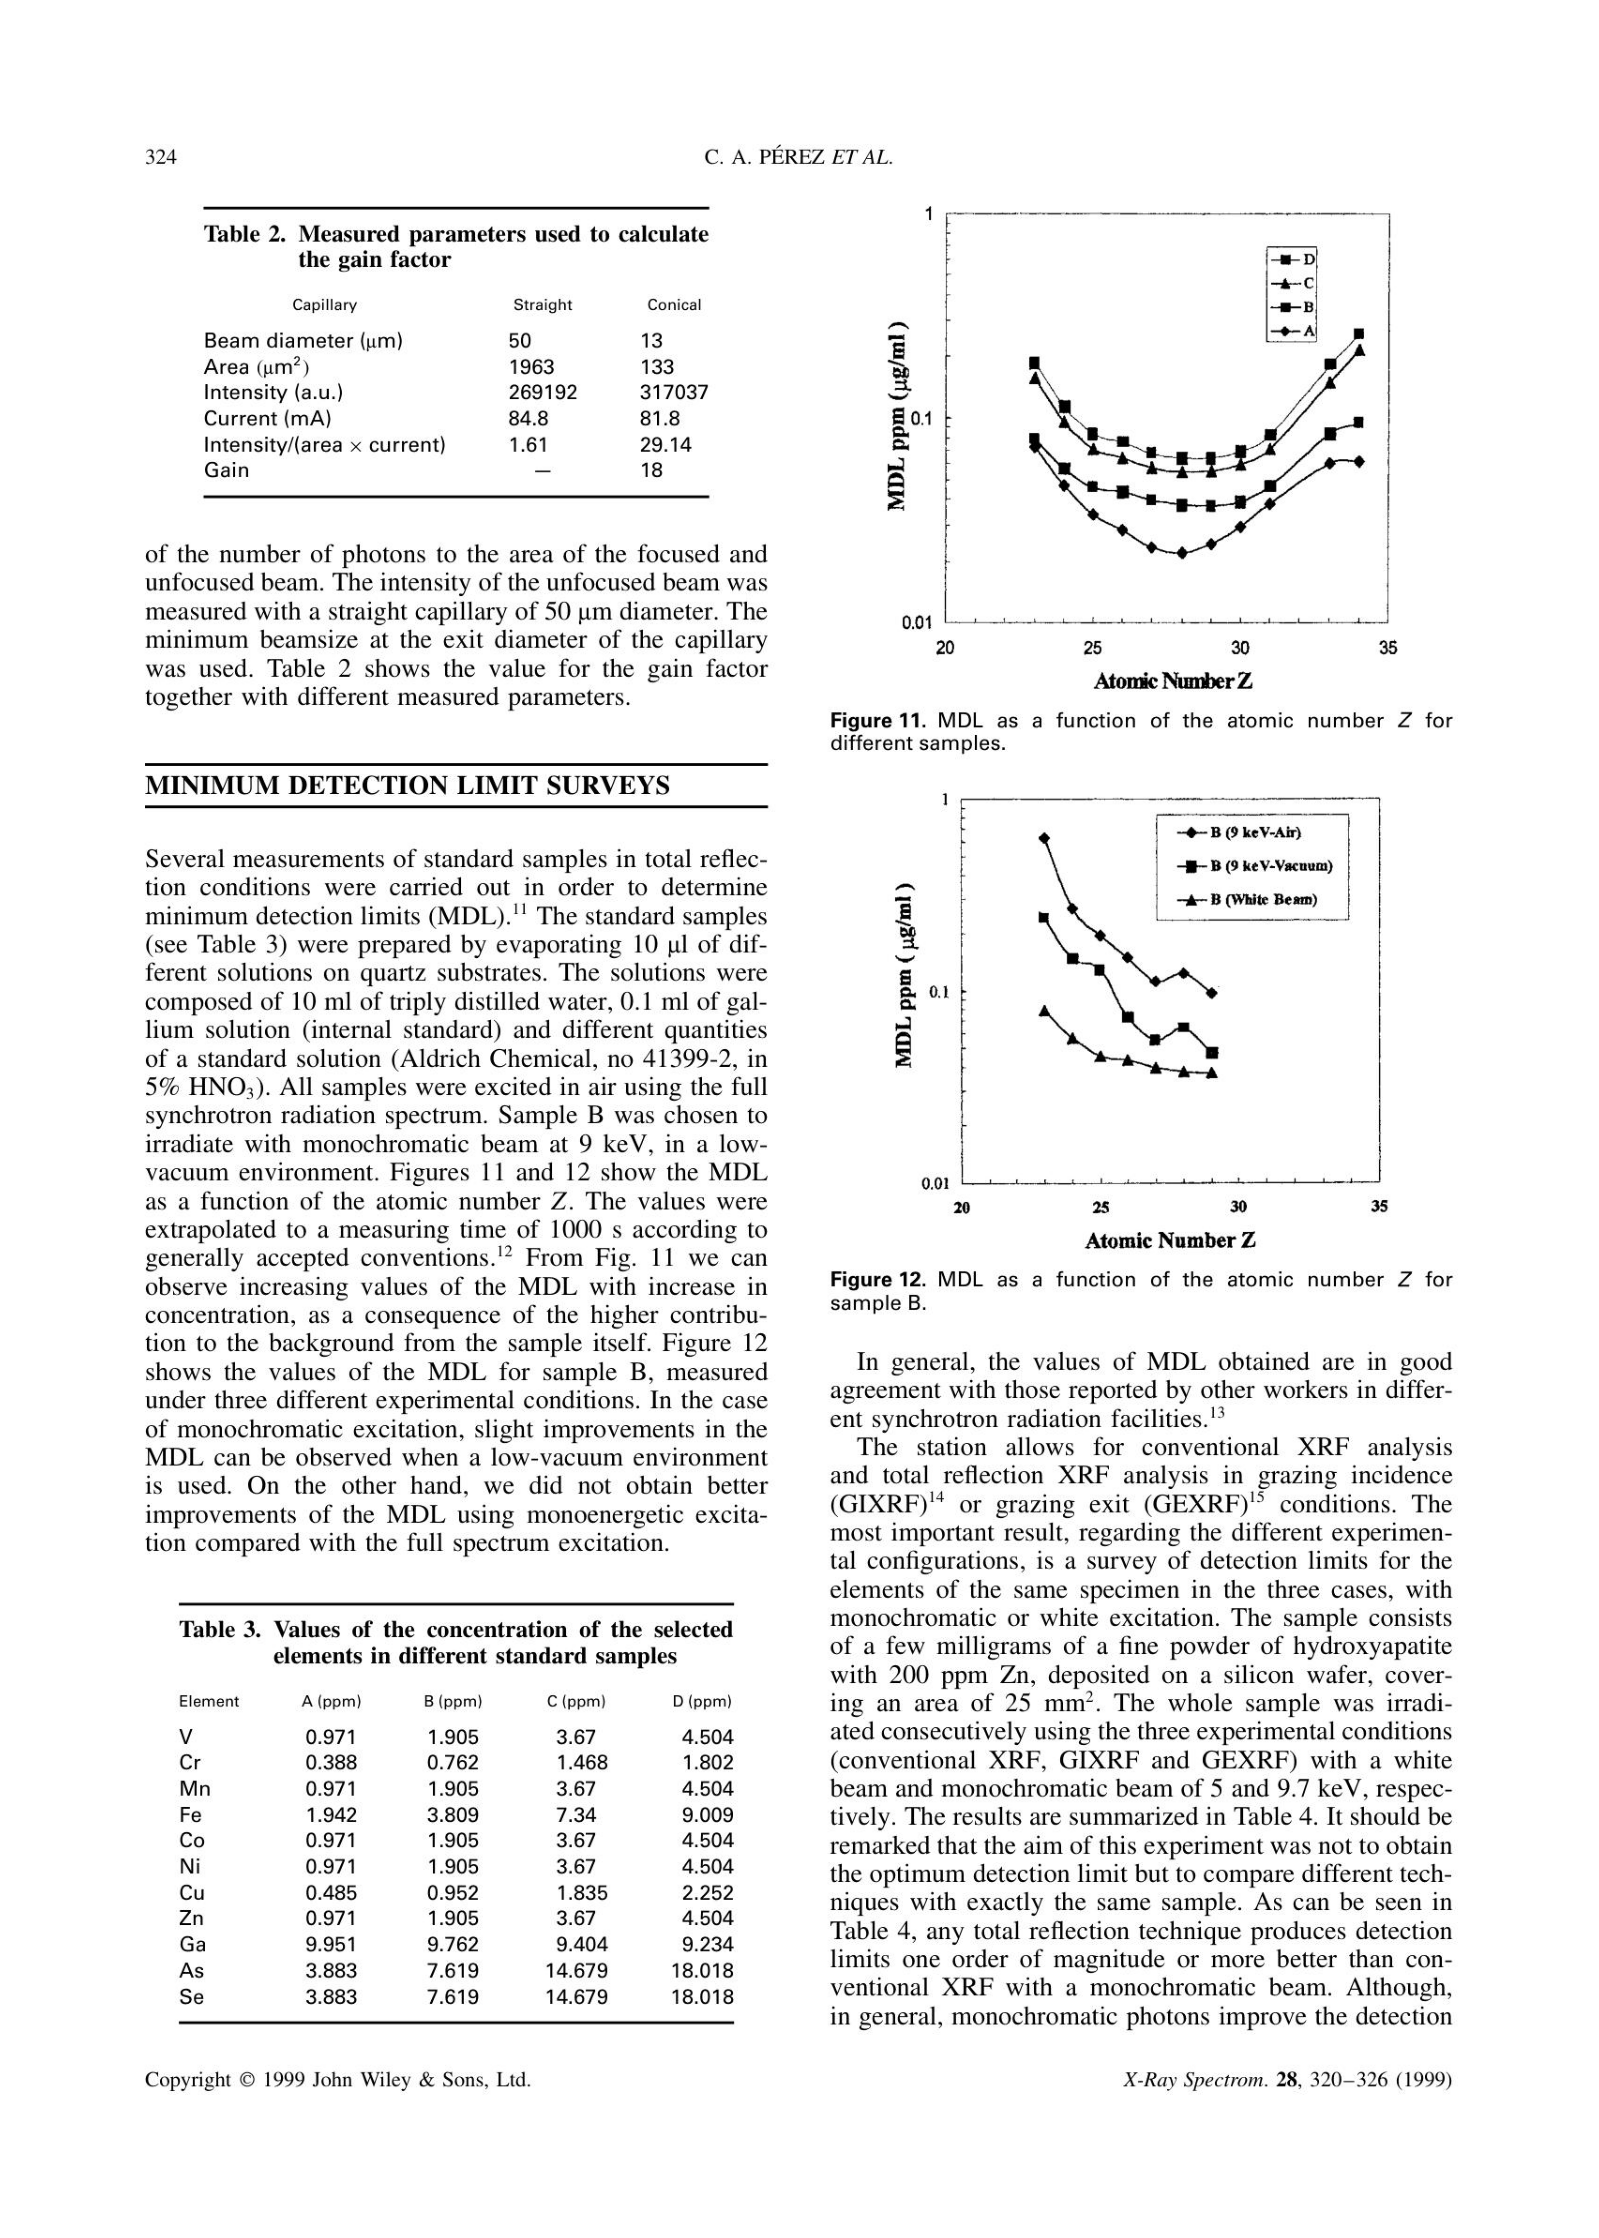

In [33]:
%matplotlib inline
from matplotlib import pyplot as plt

img_og = cv2.imread("/Users/basaravia/Documents/02_Proyectos_IA/genai/local_ocr_dl/DocLayout-YOLO/assets/example/academic.jpg")
plt.figure(figsize=(8, 12), dpi=250)
plt.imshow(img_og, aspect='equal')
plt.axis('off')
plt.show()

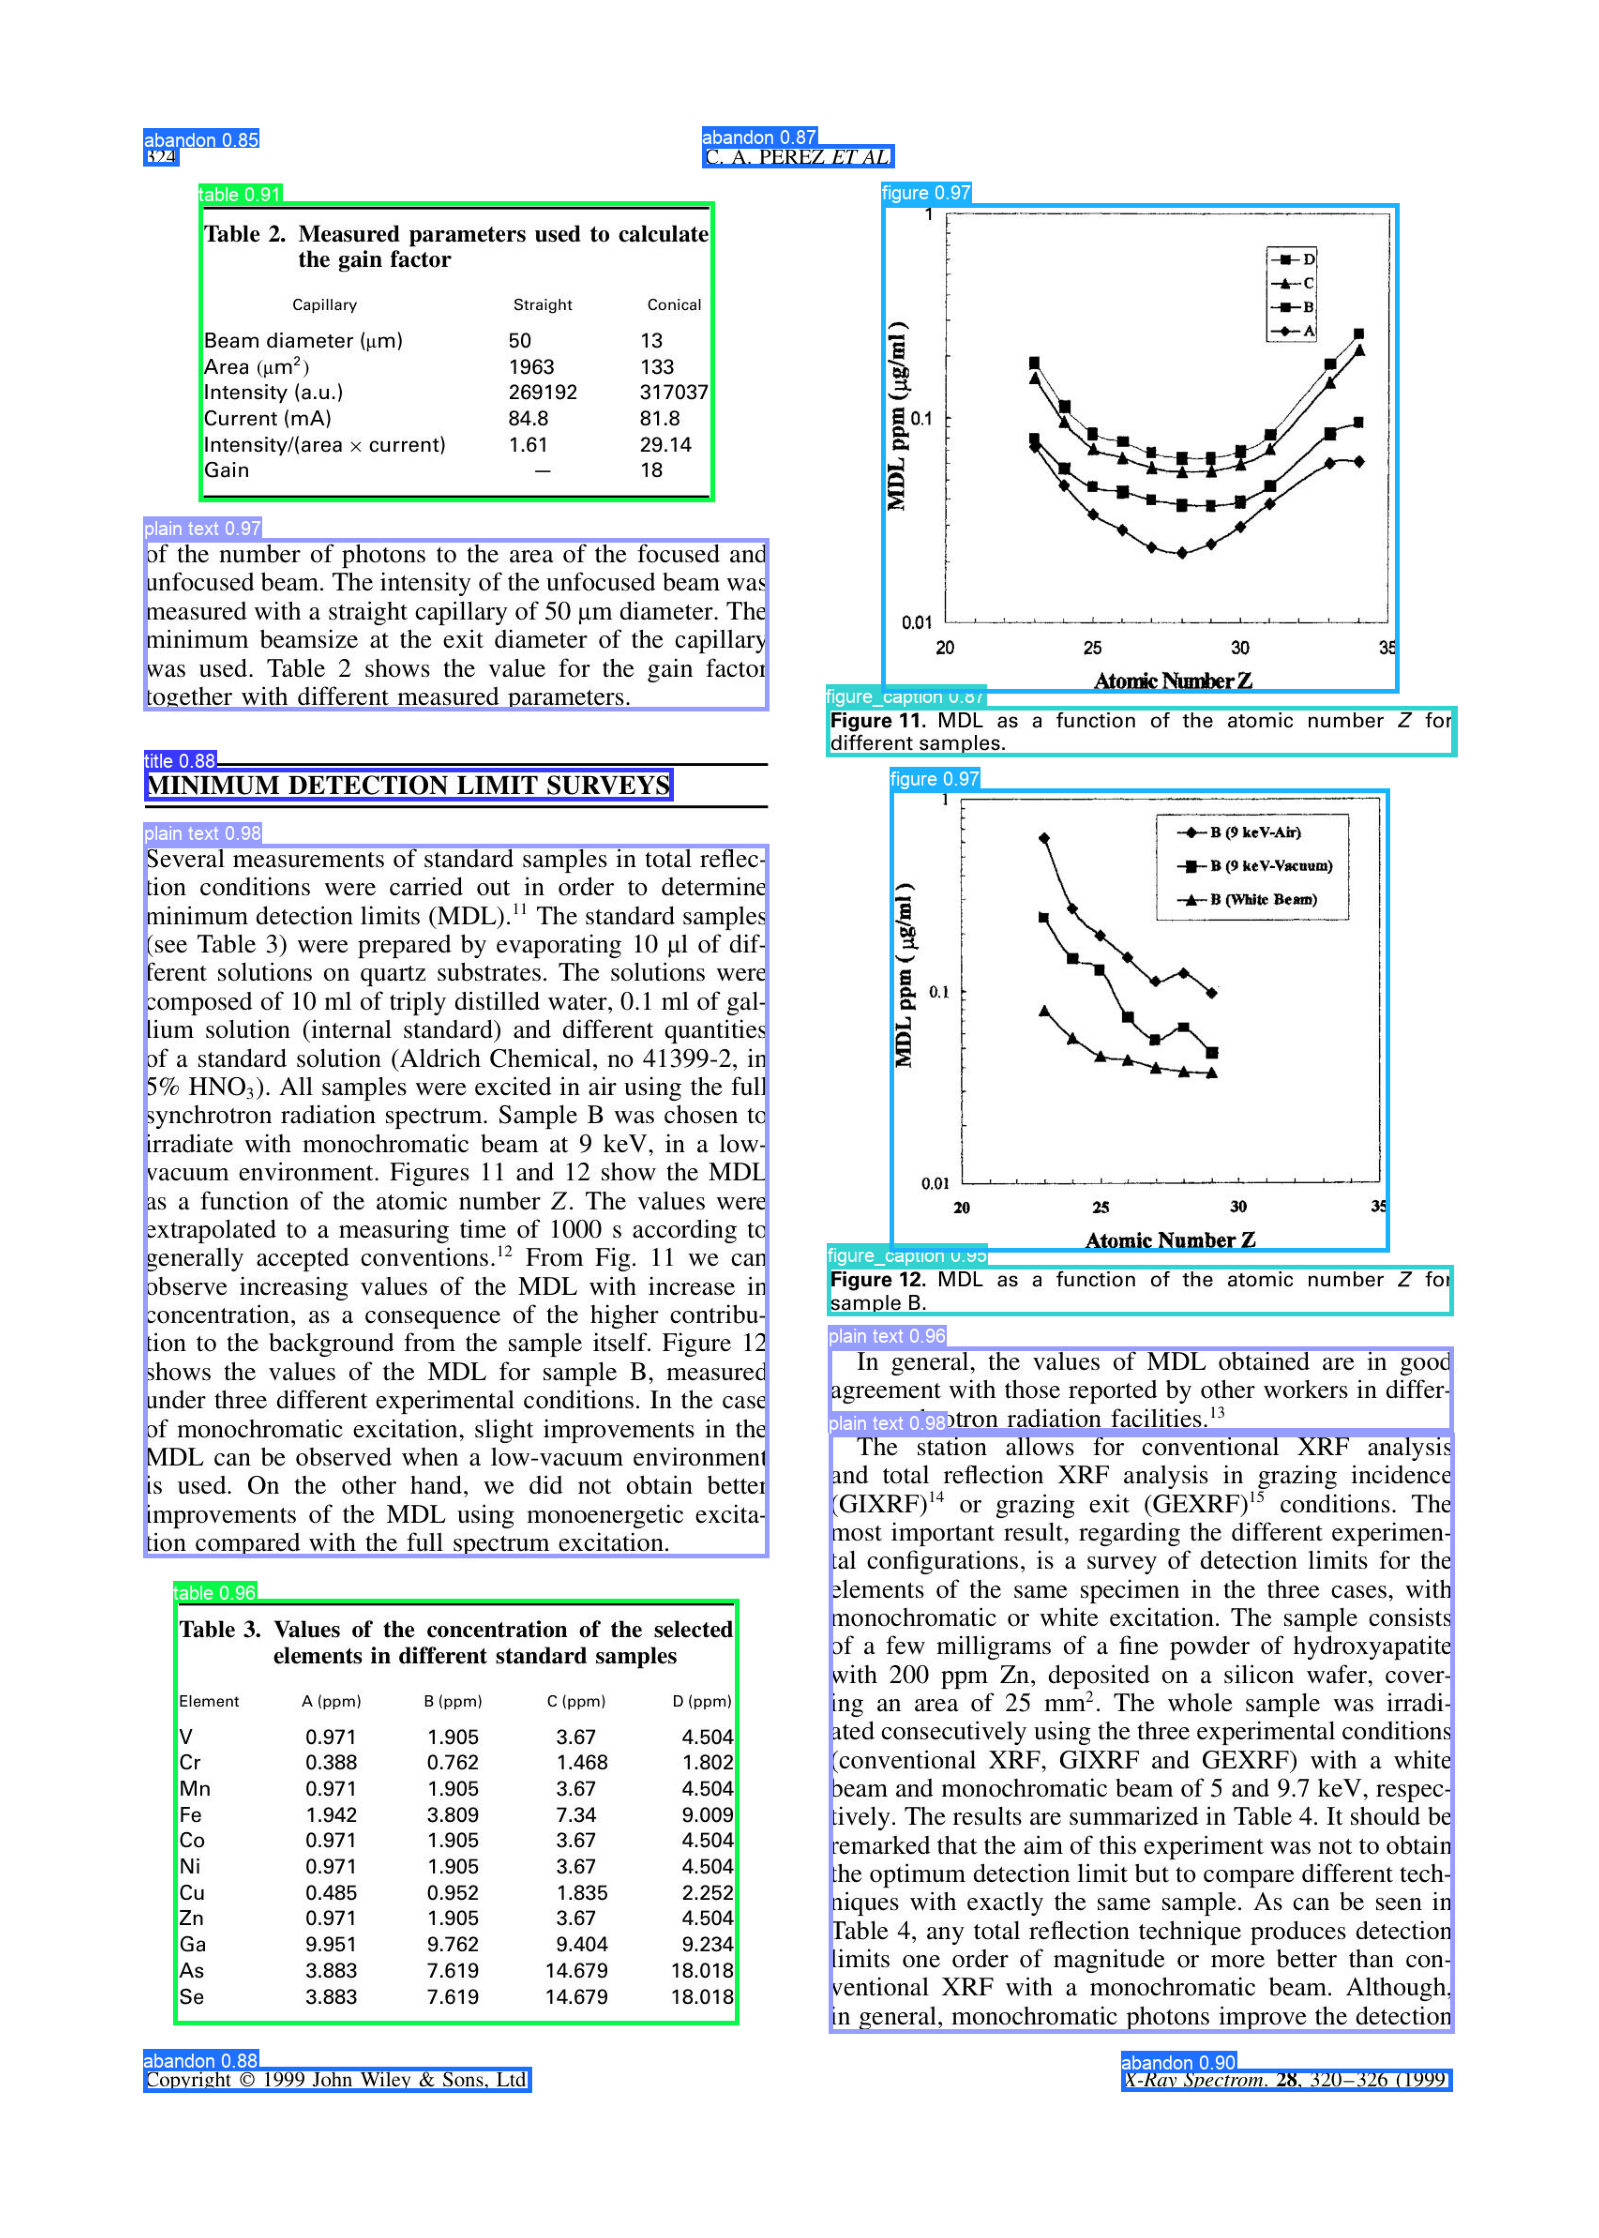

In [34]:
plt.figure(figsize=(8, 12), dpi=250)
plt.imshow(annotated_frame, aspect='equal')
plt.axis('off')
plt.show()

In [12]:
from IPython.display import Image as IPImage
from IPython.display import display

In [ ]:
import base64
import io

import fitz
from PIL import Image


def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

In [ ]:
from IPython.display import Image as IPImage
from IPython.display import display

base64_image = pdf_page_to_base64(file_path, 11)
display(IPImage(data=base64.b64decode(base64_image)))

## Langchain

Extracting tables and other structures



In [3]:
%pip install -qU langchain-unstructured

Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install -qU matplotlib PyMuPDF pillow

Note: you may need to restart the kernel to use updated packages.


# DOC Parsing Local

Parsing locally requires the installation of additional dependencies.

### Poppler (PDF analysis)

Linux: apt-get install poppler-utils

Mac: brew install poppler

Windows: https://github.com/oschwartz10612/poppler-windows

### Tesseract (OCR)

Linux: apt-get install tesseract-ocr

Mac: brew install tesseract

Windows: https://github.com/UB-Mannheim/tesseract/wiki#tesseract-installer-for-windows


---
REFS:

https://python.langchain.com/docs/how_to/document_loader_pdf/#layout-analysis-and-extraction-of-text-from-images 
https://python.langchain.com/docs/integrations/document_loaders/unstructured_file/ 

In [8]:
%pip install -qU "unstructured[pdf]"

Note: you may need to restart the kernel to use updated packages.


In [11]:
import fitz
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image


def plot_pdf_with_boxes(pdf_page, segments):
    pix = pdf_page.get_pixmap()
    pil_image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(pil_image)
    categories = set()
    category_to_color = {
        "Title": "orchid",
        "Image": "forestgreen",
        "Table": "tomato",
    }
    for segment in segments:
        points = segment["coordinates"]["points"]
        layout_width = segment["coordinates"]["layout_width"]
        layout_height = segment["coordinates"]["layout_height"]
        scaled_points = [
            (x * pix.width / layout_width, y * pix.height / layout_height)
            for x, y in points
        ]
        box_color = category_to_color.get(segment["category"], "deepskyblue")
        categories.add(segment["category"])
        rect = patches.Polygon(
            scaled_points, linewidth=1, edgecolor=box_color, facecolor="none"
        )
        ax.add_patch(rect)

    # Make legend
    legend_handles = [patches.Patch(color="deepskyblue", label="Text")]
    for category in ["Title", "Image", "Table"]:
        if category in categories:
            legend_handles.append(
                patches.Patch(color=category_to_color[category], label=category)
            )
    ax.axis("off")
    ax.legend(handles=legend_handles, loc="upper right")
    plt.tight_layout()
    plt.show()


def render_page(doc_list: list, page_number: int, print_text=True) -> None:
    pdf_page = fitz.open(file_path).load_page(page_number - 1)
    page_docs = [
        doc for doc in doc_list if doc.metadata.get("page_number") == page_number
    ]
    segments = [doc.metadata for doc in page_docs]
    plot_pdf_with_boxes(pdf_page, segments)
    if print_text:
        for doc in page_docs:
            print(f"{doc.page_content}\n")

In [32]:
from langchain_unstructured import UnstructuredLoader

file_path = "/Users/basaravia/Documents/02_Proyectos_IA/genai/local_ocr_dl/data/docs/Estados-Financieros-al-30-de-abril-de-2021.pdf"
UnstructuredLoader
loader_local = (
    file_path=file_path,
    strategy="hi_res",
    languages= ['spa']
)

docs_local = []
for doc in loader_local.lazy_load():
    docs_local.append(doc)

INFO: Reading PDF for file: /Users/basaravia/Documents/02_Proyectos_IA/genai/local_ocr_dl/data/docs/Estados-Financieros-al-30-de-abril-de-2021.pdf ...


In [33]:
#first_page_docs = [doc for doc in docs if doc.metadata.get("page_number") == 1]

first_page_docs = [doc for doc in docs_local if doc.metadata.get("page_number") == 1]

for doc in first_page_docs:
    print(doc.page_content)

UNIVERSIDAD DE SONORA
UNIVERSIDAD DE SONORA
ESTADOS FINANCIEROS ESTADOS FINANCIEROS AL 30 DE ABRIL DEL 2021 AL 30 DE ABRIL DEL 2021


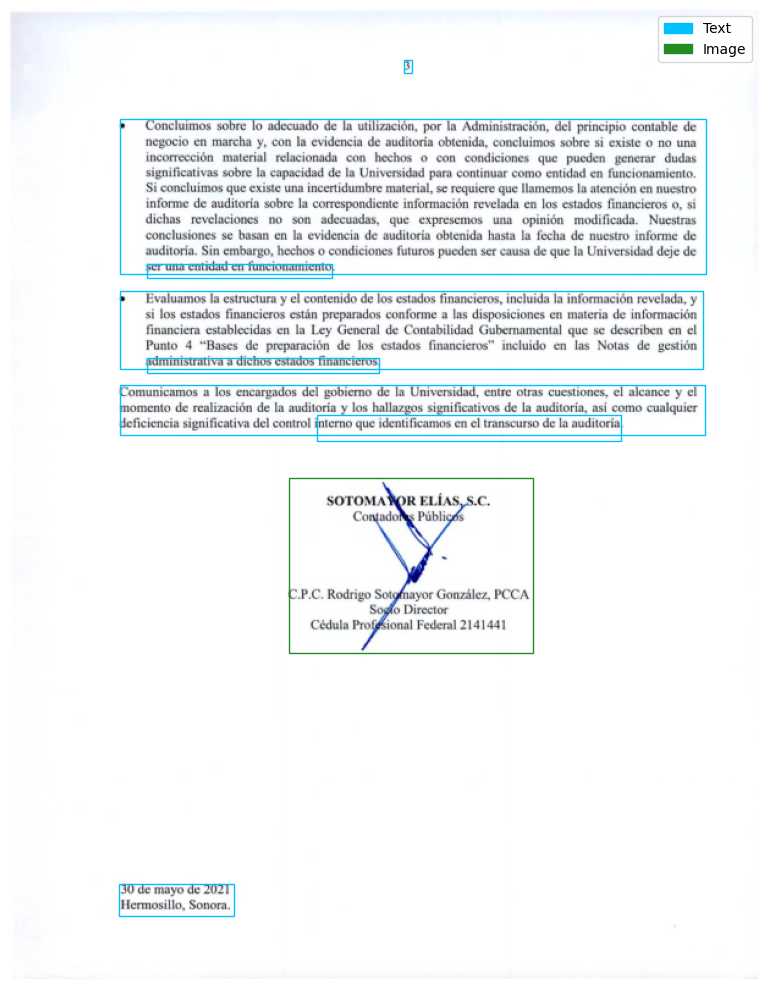

3

• Concluimos sobre lo adecuado de la utilizacion, por la Administracion, del principio contable de Concluimos sobre lo adecuado de la utilización, por la Administración, del principio contable de * negocio en marcha y, con la evidencia de auditoria obtenida, concluimos sobre si existe o no una negocio en marcha y, con la evidencia de auditoría obtenida, concluimos sobre si existe o no una incorreccion material relacionada con hechos o con condiciones que pueden generar dudas con hechos o con relacionada incorrección material condiciones que pueden generar dudas significativas sobre la capacidad de la Universidad para continuar como entidad en funcionamiento. significativas sobre la capacidad de la Universidad para continuar como entidad en funcionamiento. Si concluimosque existe una incertidumbre material, se requiere que llamemosla atención en nuestro Si concluimos que existe una incertidumbre material, se requiere que llamemos la atencion en nuestro informe de auditoria sobre la c

In [34]:
render_page(docs_local, 5)


In [30]:
segments

[{'source': '/Users/basaravia/Documents/02_Proyectos_IA/genai/local_ocr_dl/data/docs/Estados-Financieros-al-30-de-abril-de-2021.pdf',
  'detection_class_prob': 0.8248624801635742,
  'coordinates': {'points': ((np.float64(114.17485809326172),
     np.float64(421.41290283203125)),
    (np.float64(114.17485809326172), np.float64(1754.8226318359375)),
    (np.float64(1321.587646484375), np.float64(1754.8226318359375)),
    (np.float64(1321.587646484375), np.float64(421.41290283203125))),
   'system': 'PixelSpace',
   'layout_width': 1710,
   'layout_height': 2211},
  'last_modified': '2025-08-07T01:20:22',
  'filetype': 'application/pdf',
  'languages': ['spa'],
  'page_number': 11,
  'file_directory': '/Users/basaravia/Documents/02_Proyectos_IA/genai/local_ocr_dl/data/docs',
  'filename': 'Estados-Financieros-al-30-de-abril-de-2021.pdf',
  'category': 'Table',
  'element_id': '0bf84af6cbb19b16b06758fd701cad87'}]

In [29]:
from IPython.display import HTML, display

segments = [
    doc.metadata
    for doc in docs_local
    if doc.metadata.get("page_number") == 11 and doc.metadata.get("category") == "Table"
]

display(HTML(segments[0]["text_as_html"]))



KeyError: 'text_as_html'

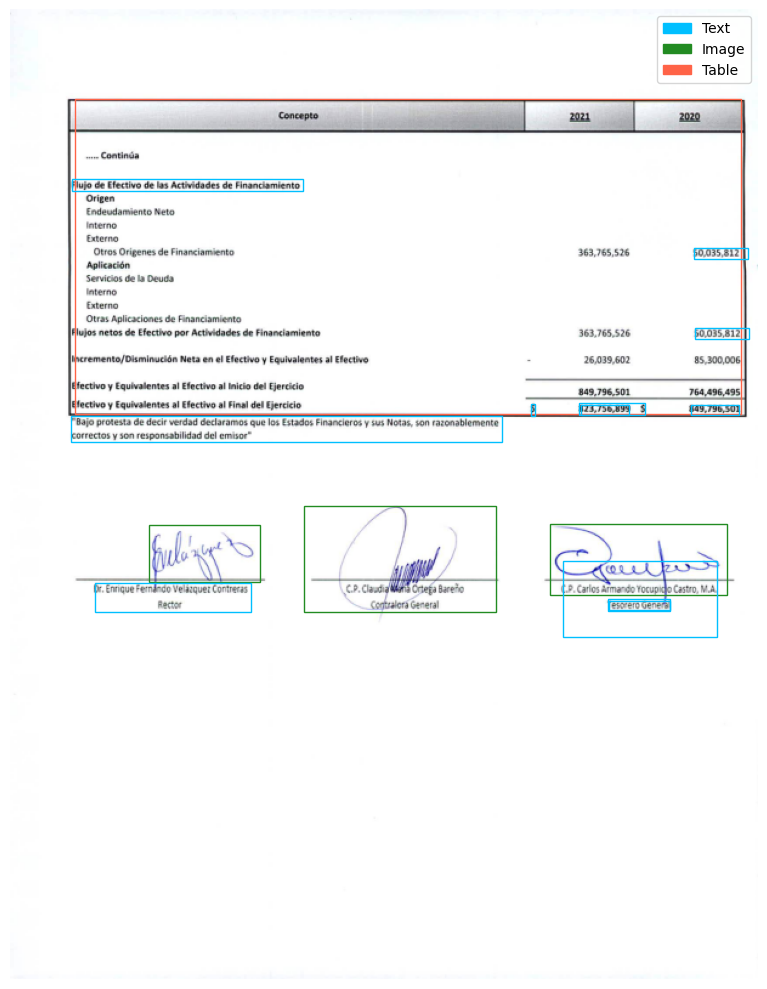

In [ ]:
render_page(docs_local, 14, print_text=False)

In [22]:
conclusion_docs = []
parent_id = -1
for doc in docs_local:
    if doc.metadata["category"] == "Title" and "Conclusion" in doc.page_content:
        parent_id = doc.metadata["element_id"]
    if doc.metadata.get("parent_id") == parent_id:
        conclusion_docs.append(doc)

for doc in conclusion_docs:
    print(doc.page_content)


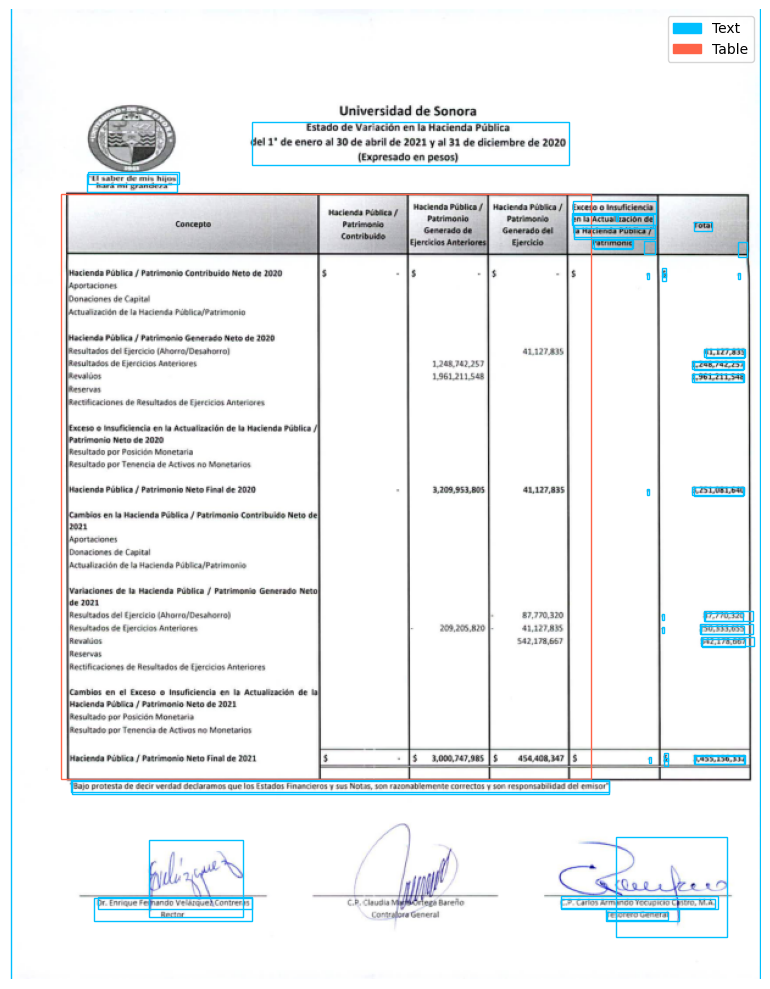

3,000,747,985|$

Estado de Variacion en la Hacienda Publica Estado de Variación en la Hacienda Pública del 1° de enero al 30 de abril de 2021 y al 31 de diciembre de 2020 del 1* de enero al 30 de abril de 2021 y al 31 de diciembre de 2020 (Expresado en pesos) (Expresado en pesos)

"'ll &Aber de mis hijos

“El saber de mis hijos har4 mi grande/a" hará mi grandeza”

Hacienda Publica / Hacienda Publica / Hacienda Publica / Hacienda Pública/ r Patrimonio Patrimonio Patrimonio Patrimonio Patrimonio Concepto PRIdanida concepto Generado de Generado del Generadodel Generado de Contribuido Ejercicios Anteriores Ejercicio Ejercicios Anteriores Ejercicio == Hacienda Publica / Patrimonio Contribuido Neto de 2020 $ $ $ $ Hacienda Pública / Patrimonio Contribuido Neto de 2020 $ $ - - - 1$ 1$ Aportaciones Aportaciones Donaciones de Capital Donacionesde Capital Actualizacion de la Hacienda Publica/Patrimonio Actualización de la Hacienda Pública/Patrimonio Hacienda Publica / Patrimonio Generado Neto de

In [23]:

render_page(docs_local, 11)

## Text Extract

In [25]:
%pip install -qU pypdf

Note: you may need to restart the kernel to use updated packages.


In [26]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [27]:
print(f"{pages[0].metadata}\n")
print(pages[0].page_content)


{'producer': 'PDFsharp 1.50.4589 (www.pdfsharp.com)', 'creator': 'NAPS2', 'creationdate': '2021-06-14T18:05:54-07:00', 'author': 'NAPS2', 'keywords': '', 'subject': 'Imagen escaneada', 'title': 'Imagen escaneada', 'moddate': '2021-06-14T18:05:54-07:00', 'source': '/Users/basaravia/Documents/02_Proyectos_IA/genai/local_ocr_dl/data/docs/Estados-Financieros-al-30-de-abril-de-2021.pdf', 'total_pages': 38, 'page': 0, 'page_label': '1'}

UNIVERSIDAD DE SONORA
ESTADOS FINANCIEROS
AL 30 DE ABRIL DEL 2021
UNIVERSIDAD DE SONORA
ESTADOS FINANCIEROS 
AL 30 DE ABRIL DEL 2021


In [28]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings

vector_store = InMemoryVectorStore.from_documents(pages, OpenAIEmbeddings())
docs = vector_store.similarity_search("What is LayoutParser?", k=2)
for doc in docs:
    print(f"Page {doc.metadata['page']}: {doc.page_content[:300]}\n")

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable